# Data Collection and Cleaning

Data has been collected from both the EPA for Air Quality Index data and from the CDC for birth data relating to weight.  

## Imports

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

## Data

### EPA AQI Data

Looking at example data that Winston collected via API

In [107]:
# df = pd.read_csv('data/AQS_data_test_Alabama_2006.csv')

In [108]:
# df.head()

In [109]:
# df.columns

In [110]:
# df.drop(['Unnamed: 0', 'state_code', 'county_code'], axis=1, inplace=True)

In [111]:
# df.shape

In [112]:
# df['county'].unique()

In [113]:
# df[(df['state'] == 'Alabama') & (df['county'] == 'Shelby')]['pollutant_standard'].unique()

#### Import Data

The air quality data was downloaded from https://aqs.epa.gov/aqsweb/airdata/download_files.html#Annual as files containing annual data from years 2016-2021.  We are combining these CSV files into a single dataframe and will evaluate whether it will meet the needs for the project, or whether data will need to be collected through the API that the EPA offers for AirData.

In [114]:
# code from Winston merged with approach from
# https://towardsdatascience.com/pandas-concat-tricks-you-should-know-to-speed-up-your-data-analysis-cd3d4fdfe6dd

data_path = Path('data/')

# create a list of all the AQI csv files
dfs = (
    pd.read_csv(file) for file in data_path.glob('*_aqi_*') if file.is_file()
)

# concatenate the dataframes
res = pd.concat(dfs)

# export the final csv
res.to_csv('data/aqi_by_year_2006-2021.csv', index=False)

Read the final CSV for all the AQI data

In [115]:
aqi = pd.read_csv('data/aqi_by_year_2006-2021.csv')

#### General Look and Cleanup

In [116]:
aqi.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
0,Alabama,Baldwin,2009,252,218,32,2,0,0,0,136,53,36,0,0,200,52,0
1,Alabama,Clay,2009,119,97,22,0,0,0,0,94,59,33,0,0,0,119,0
2,Alabama,Colbert,2009,323,220,103,0,0,0,0,76,60,43,0,0,132,191,0
3,Alabama,DeKalb,2009,363,311,52,0,0,0,0,100,54,36,0,0,308,55,0
4,Alabama,Elmore,2009,244,228,16,0,0,0,0,80,49,36,0,0,244,0,0


In [117]:
aqi.columns

Index(['State', 'County', 'Year', 'Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days PM2.5', 'Days PM10'],
      dtype='object')

In [118]:
aqi.shape

(16751, 18)

In [119]:
aqi.dtypes

State                                  object
County                                 object
Year                                    int64
Days with AQI                           int64
Good Days                               int64
Moderate Days                           int64
Unhealthy for Sensitive Groups Days     int64
Unhealthy Days                          int64
Very Unhealthy Days                     int64
Hazardous Days                          int64
Max AQI                                 int64
90th Percentile AQI                     int64
Median AQI                              int64
Days CO                                 int64
Days NO2                                int64
Days Ozone                              int64
Days PM2.5                              int64
Days PM10                               int64
dtype: object

In [120]:
aqi.columns = [col.lower().replace(' ', '_') for col in aqi.columns]

In [121]:
aqi.columns

Index(['state', 'county', 'year', 'days_with_aqi', 'good_days',
       'moderate_days', 'unhealthy_for_sensitive_groups_days',
       'unhealthy_days', 'very_unhealthy_days', 'hazardous_days', 'max_aqi',
       '90th_percentile_aqi', 'median_aqi', 'days_co', 'days_no2',
       'days_ozone', 'days_pm2.5', 'days_pm10'],
      dtype='object')

#### Rename Columns
Mainly to trim the length of some of the column names to make it easier to work with.

In [123]:
aqi.rename(columns={
    'moderate_days': 'mod_days',
    'unhealthy_for_sensitive_groups_days': 'uh_sens_days',
    'unhealthy_days': 'uh_days',
    'very_unhealthy_days': 'v_uh_days',
    'hazardous_days': 'haz_days',
    '90th_percentile_aqi': '90_per_aqi'
    }, inplace=True)

In [124]:
aqi.isnull().sum()[aqi.isnull().sum() > 0]

Series([], dtype: int64)

In [125]:
aqi[['state', 'county']].nunique()

state      55
county    913
dtype: int64

In [126]:
aqi['state'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Country Of Mexico', 'Delaware',
       'District Of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming', 'Canada'], dtype=object)

May want to drop locations such as:
* Country of Mexico
* Puerto Rico
* Virgin Islands
* Canada

In [127]:
aqi.drop(
    aqi[
        aqi['state'].isin(
            ['Country Of Mexico', 'Puerto Rico', 'Virgin Islands', 'Canada']
        )
    ].index, inplace=True)

In [128]:
# aqi['county'].unique()

In [129]:
aqi.head(3)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,max_aqi,90_per_aqi,median_aqi,days_co,days_no2,days_ozone,days_pm2.5,days_pm10
0,Alabama,Baldwin,2009,252,218,32,2,0,0,0,136,53,36,0,0,200,52,0
1,Alabama,Clay,2009,119,97,22,0,0,0,0,94,59,33,0,0,0,119,0
2,Alabama,Colbert,2009,323,220,103,0,0,0,0,76,60,43,0,0,132,191,0


In [130]:
aqi.describe()

,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,max_aqi,90_per_aqi,median_aqi,days_co,days_no2,days_ozone,days_pm2.5,days_pm10
count,16501.000000,16501.000000,16501.000000,16501.000000,16501.000000,16501.000000,16501.000000,16501.000000,16501.000000,16501.000000,16501.000000,16501.000000,16501.000000,16501.000000,16501.000000,16501.000000
mean,2013.383553,306.444882,234.848615,65.491546,5.049815,0.913581,0.094297,0.047027,127.411430,61.653718,37.645961,0.981395,6.662748,171.259802,113.697594,13.843343
std,4.606053,89.581053,82.748368,51.767296,10.383965,4.010658,1.102704,0.678479,223.144948,19.370126,10.936383,12.174014,26.480857,119.199918,110.491615,52.573798
min,2006.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2009.000000,256.000000,177.000000,26.000000,0.000000,0.000000,0.000000,0.000000,90.000000,50.000000,33.000000,0.000000,0.000000,59.000000,0.000000,0.000000
50%,2013.000000,360.000000,250.000000,53.000000,1.000000,0.000000,0.000000,0.000000,112.000000,59.000000,39.000000,0.000000,0.000000,187.000000,95.000000,0.000000
75%,2017.000000,365.000000,304.000000,94.000000,6.000000,0.000000,0.000000,0.000000,146.000000,71.000000,44.000000,0.000000,0.000000,245.000000,185.000000,1.000000
max,2021.000000,366.000000,365.000000,339.000000,122.000000,92.000000,74.000000,37.000000,14043.000000,306.000000,132.000000,365.000000,365.000000,366.000000,366.000000,366.000000


All the values seem like they would be in range--meaning no negative counts, no days over 366.

### CDC Data

Want to import the CDC data and compare the counties.

We are using the WONDER tool from the CDC to export the files that we are importing to this notebook. For both files, we filtered out any births with maternal risk factors so we they are not influencing birth weight.  There are some years that have no or suppressed data, which are omitted from the CDC export and are not present.We filtered out any births with maternal risk factors so we they are not influencing birth weight.  There are some years that have no or suppressed data, which are omitted from the CDC export and are not present. 

There are two main files:
1. `Natality_low_2007-2021` which represents all the births below 2500 grams by year and county. 
1. `Natality_all_2007-2021` which represents all the births by year and county.

#### Import Data

In [131]:
cdc_low = pd.read_csv('data/Natality_low_2007-2021.txt', sep='\t')
cdc_all = pd.read_csv('data/Natality_all_2007-2021.txt', sep='\t')

#### General Look and Cleanup

In [132]:
cdc_low.head()

,Notes,State,State Code,County,County Code,Year,Year Code,Births,Average Birth Weight,Average LMP Gestational Age,Average OE Gestational Age
0,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2014.0,2014.0,137.0,1995.255,34.241,34.051
1,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2015.0,2015.0,141.0,1832.837,32.965,32.922
2,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2016.0,2016.0,120.0,2008.358,34.467,34.058
3,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2017.0,2017.0,100.0,2082.830,34.550,34.380
4,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2018.0,2018.0,122.0,1942.303,33.762,33.508


In [133]:
cdc_all.head()

,Notes,State,State Code,County,County Code,Year,Year Code,Births,Average Birth Weight,Average LMP Gestational Age,Average OE Gestational Age
0,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2014.0,2014.0,1724.0,3296.472,38.595,38.489
1,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2015.0,2015.0,1857.0,3290.811,38.487,38.347
2,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2016.0,2016.0,1722.0,3315.387,38.690,38.497
3,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2017.0,2017.0,1782.0,3346.588,38.713,38.572
4,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2018.0,2018.0,1770.0,3301.324,38.580,38.423


In [134]:
cdc_low.dtypes

Notes                           object
State                           object
State Code                     float64
County                          object
County Code                    float64
Year                           float64
Year Code                      float64
Births                         float64
Average Birth Weight           float64
Average LMP Gestational Age    float64
Average OE Gestational Age     float64
dtype: object

In [135]:
cdc_all.dtypes

Notes                           object
State                           object
State Code                     float64
County                          object
County Code                    float64
Year                           float64
Year Code                      float64
Births                         float64
Average Birth Weight           float64
Average LMP Gestational Age    float64
Average OE Gestational Age     float64
dtype: object

In [136]:
cdc_low.shape

(6712, 11)

In [137]:
cdc_all.shape

(6715, 11)

In [138]:
cdc_low.columns, cdc_all.columns

(Index(['Notes', 'State', 'State Code', 'County', 'County Code', 'Year',
        'Year Code', 'Births', 'Average Birth Weight',
        'Average LMP Gestational Age', 'Average OE Gestational Age'],
       dtype='object'),
 Index(['Notes', 'State', 'State Code', 'County', 'County Code', 'Year',
        'Year Code', 'Births', 'Average Birth Weight',
        'Average LMP Gestational Age', 'Average OE Gestational Age'],
       dtype='object'))

In [139]:
cdc_low.columns = [col.lower().replace(' ', '_') for col in cdc_low.columns]
cdc_all.columns = [col.lower().replace(' ', '_') for col in cdc_all.columns]

Renaming the % of births column, and if we want different names for other columns, we can do it at this step

In [140]:
cdc_low.columns

Index(['notes', 'state', 'state_code', 'county', 'county_code', 'year',
       'year_code', 'births', 'average_birth_weight',
       'average_lmp_gestational_age', 'average_oe_gestational_age'],
      dtype='object')

In [141]:
cdc_low['notes'].nunique(), cdc_all['notes'].nunique()

(91, 87)

In [142]:
# cdc_all['notes'].unique()

All the notes look like they are what shows up at the bottom of the file and isn't data that we're looking for.  Dropping the notes column

In [143]:
cdc_low.drop(['notes'], axis=1, inplace=True)
cdc_all.drop(['notes'], axis=1, inplace=True)

In [144]:
cdc_low.isna().sum()[cdc_low.isna().sum() > 0]

state                          96
state_code                     96
county                         96
county_code                    96
year                           96
year_code                      96
births                         96
average_birth_weight           96
average_lmp_gestational_age    96
average_oe_gestational_age     96
dtype: int64

In [145]:
cdc_all.isna().sum()[cdc_all.isna().sum() > 0]

state                          92
state_code                     92
county                         92
county_code                    92
year                           92
year_code                      92
births                         92
average_birth_weight           92
average_lmp_gestational_age    92
average_oe_gestational_age     92
dtype: int64

In [146]:
cdc_low.tail(3)

,state,state_code,county,county_code,year,year_code,births,average_birth_weight,average_lmp_gestational_age,average_oe_gestational_age
6709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
cdc_all.tail(3)

,state,state_code,county,county_code,year,year_code,births,average_birth_weight,average_lmp_gestational_age,average_oe_gestational_age
6712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We need state and county information for this project,and it looks like all these null values belong, possibly to rows that were holding that notes data.  Dropping these rows to see if that clears up all the nulls.

Drop the rows that have the footnotes in them

In [148]:
cdc_low.dropna(subset=['state'], inplace=True)
cdc_all.dropna(subset=['state'], inplace=True)

In [149]:
cdc_low.isna().sum()[cdc_low.isna().sum() > 0]

Series([], dtype: int64)

In [150]:
cdc_all.isna().sum()[cdc_all.isna().sum() > 0]

Series([], dtype: int64)

That did resolve all the null values.

In [151]:
cdc_low.shape, cdc_all.shape

((6616, 10), (6623, 10))

In [152]:
cdc_low.tail(3)

,state,state_code,county,county_code,year,year_code,births,average_birth_weight,average_lmp_gestational_age,average_oe_gestational_age
6613,Wyoming,56.0,"Unidentified Counties, WY",56999.0,2019.0,2019.0,335.0,2062.824,35.051,34.919
6614,Wyoming,56.0,"Unidentified Counties, WY",56999.0,2020.0,2020.0,307.0,2088.586,35.365,34.987
6615,Wyoming,56.0,"Unidentified Counties, WY",56999.0,2021.0,2021.0,319.0,2063.197,34.821,34.862


In [153]:
cdc_all.tail(3)

,state,state_code,county,county_code,year,year_code,births,average_birth_weight,average_lmp_gestational_age,average_oe_gestational_age
6620,Wyoming,56.0,"Unidentified Counties, WY",56999.0,2019.0,2019.0,4592.0,3218.040,38.709,38.636
6621,Wyoming,56.0,"Unidentified Counties, WY",56999.0,2020.0,2020.0,4285.0,3228.561,38.733,38.641
6622,Wyoming,56.0,"Unidentified Counties, WY",56999.0,2021.0,2021.0,4379.0,3227.242,38.608,38.551


It looks like year and year_code might contain the same data

In [154]:
(cdc_low['year'] == cdc_low['year_code']).sum() == cdc_low.shape[0]

True

`year` and `year_code` appear to be the same.  We also don't have state or county codes in the EPA data, so dropping those as well.

In [155]:
cdc_low.drop(['year_code', 'county_code', 'state_code'], axis=1, inplace=True)
cdc_all.drop(['year_code', 'county_code', 'state_code'], axis=1, inplace=True)

Also want the year as an int not a float

In [156]:
cdc_low['year'] = cdc_low['year'].astype(int)
cdc_all['year'] = cdc_all['year'].astype(int)

In [157]:
cdc_low.columns

Index(['state', 'county', 'year', 'births', 'average_birth_weight',
       'average_lmp_gestational_age', 'average_oe_gestational_age'],
      dtype='object')

#### Gestational Age at Birth
Beginning in 2014 NCHS changed the standard for gestational period from the Last Menstrual Period (LMP) based gestational age to the Obstetric/clinical Estimate (OE) based gestational age. Obstetric/clinical Estimate (OE) based gestational age groups are available for years 2007 and later in WONDER since February 2016. Refer to [Measuring Gestational Age in Vital Statistics Data: Transitioning to the Obstetric Estimate](http://www.cdc.gov/nchs/data/nvsr/nvsr64/nvsr64_05.pdf) for more information.

I believe this means this means we should drop the LMP column and keep the OE column.

In [158]:
cdc_low.drop(['average_lmp_gestational_age'], axis=1, inplace=True)
cdc_all.drop(['average_lmp_gestational_age'], axis=1, inplace=True)

In [159]:
cdc_low.columns

Index(['state', 'county', 'year', 'births', 'average_birth_weight',
       'average_oe_gestational_age'],
      dtype='object')

#### Rename Columns

To prepare for merging this data, giving the columns specific names to indicate which dataframe they came from.

In [160]:
cdc_low.rename(columns={
    'births': 'births_low',
    'average_birth_weight': 'avg_weight_low',
    'average_oe_gestational_age': 'avg_ges_age_low'
    }, inplace=True)

cdc_all.rename(columns={
    'births': 'births_all',
    'average_birth_weight': 'avg_weight_all',
    'average_oe_gestational_age': 'avg_ges_age_all'
    }, inplace=True)

In [161]:
cdc_low.head(3)

,state,county,year,births_low,avg_weight_low,avg_ges_age_low
0,Alabama,"Baldwin County, AL",2014,137.0,1995.255,34.051
1,Alabama,"Baldwin County, AL",2015,141.0,1832.837,32.922
2,Alabama,"Baldwin County, AL",2016,120.0,2008.358,34.058


In [162]:
cdc_all.head(3)

,state,county,year,births_all,avg_weight_all,avg_ges_age_all
0,Alabama,"Baldwin County, AL",2014,1724.0,3296.472,38.489
1,Alabama,"Baldwin County, AL",2015,1857.0,3290.811,38.347
2,Alabama,"Baldwin County, AL",2016,1722.0,3315.387,38.497


#### Merge Data

Before further cleaning, the dataframes will be merged.  The low birthweight dataframe `cdc_low` is the main data and we will supplement that with the all birthweight data `cdc_all` so we should end up with a single dataframe that contains 1 entry for each year/county combination that has both the low birthweight and all birthweight data.

In [163]:
cdc = pd.merge(cdc_low, cdc_all, how='left', on=['state', 'county', 'year'])

In [164]:
cdc.head()

,state,county,year,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all
0,Alabama,"Baldwin County, AL",2014,137.0,1995.255,34.051,1724.0,3296.472,38.489
1,Alabama,"Baldwin County, AL",2015,141.0,1832.837,32.922,1857.0,3290.811,38.347
2,Alabama,"Baldwin County, AL",2016,120.0,2008.358,34.058,1722.0,3315.387,38.497
3,Alabama,"Baldwin County, AL",2017,100.0,2082.830,34.380,1782.0,3346.588,38.572
4,Alabama,"Baldwin County, AL",2018,122.0,1942.303,33.508,1770.0,3301.324,38.423


#### County Names

In [165]:
cdc['county'].sample(10)

5954         Tom Green County, TX
5132            Marion County, OR
2561         Jefferson Parish, LA
5763         Jefferson County, TX
3857            Broome County, NY
4978    Unidentified Counties, OH
3198           Olmsted County, MN
5269              Erie County, PA
1851           LaSalle County, IL
4783             Lucas County, OH
Name: county, dtype: object

I ran the sample code above multiple times to see some of the data in the county column.  Looks like they are including the state abbreviation in the County name, so will remove that.  There were also some places that didn't say "County" and said "Counties" (i.e. Unidentified Counties, WY) and also there were some locations that were parishes (in LA) or other unique monikers like Borough.  So I'm splitting on both the " Count" to capture County and Counties as well as "," to get both cases.

We should look at what the AQI data has and decide whether we need to treat the remaining unique naming cases that remain after this clean up.

In [166]:
cdc['county'] = cdc['county'
                   ].apply(lambda x: x.split(' Count')[0].split(',')[0].title())

In [167]:
cdc[['state', 'county']].nunique()

state      50
county    466
dtype: int64

In [168]:
cdc['county'].sample(10)

5240       Centre
4801     Mahoning
186          Yuma
3650       Camden
1914       Peoria
1888        Macon
3977      Niagara
4110     Rockland
2735    Baltimore
19         Etowah
Name: county, dtype: object

This looks more like what I would expect where it is just the name of the county.  Since we also saw that there were unidentified counties, and they are all just listed as Unidentified now, we should drop that data since we are trying to investigate county air quality and county birth weights, so without a specific county, the data is not valuable to us.

In [169]:
# looking through all the unique values for anything else interesting
# cdc['county'].unique()

I'm also seeing many counties that end in lower case 'city' so investigating some of those, like:
* St. Louis city
* Chesapeake city
* Norfolk city
* Portsmouth city

St. Louis is interesting, since it sounds like the city is a county, but there is also a St. Louis county that surrounds the city according to https://www.stlouis-mo.gov/government/about/city-government-structure.cfm

Chesapeake, Virginia is also an independent city and not part of a county https://en.wikipedia.org/wiki/Chesapeake,_Virginia

Given this information and the information above about seeing some "parish" listings in Louisiana, we checked against the AQI county listings and found that in the AQI data:
* the word Parish does not appear, but the name of the Parish does--like 'East Baton Rouge', so we should drop 'Parish' from the CDC county names.
* The word City does appear in the AQI data, but it is capitalized, so we should title case the CDC data or make all of them lower case when we go to match them up (this has been incorporated into earlier cleaning steps and is no longer a concern)

In [170]:
# drop parish
cdc['county'] = cdc['county'
                   ].apply(lambda x: x.split(' Parish')[0])

In [171]:
cdc.shape

(6616, 9)

In [172]:
cdc.drop(cdc[cdc['county'] == 'Unidentified'].index, inplace=True)

In [173]:
cdc.shape

(6094, 9)

In [174]:
cdc.dtypes

state               object
county              object
year                 int64
births_low         float64
avg_weight_low     float64
avg_ges_age_low    float64
births_all         float64
avg_weight_all     float64
avg_ges_age_all    float64
dtype: object

#### Calculate Percent of Low Birthweight

We have the total births and the low birthweight births, so let's create a percentage of low birthrate births before exporting the cleaned data.

In [175]:
cdc['pct_low'] = (cdc['births_low'] / cdc['births_all']).round(3)

In [176]:
cdc.head(10)

,state,county,year,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low
0,Alabama,Baldwin,2014,137.0,1995.255,34.051,1724.0,3296.472,38.489,0.079
1,Alabama,Baldwin,2015,141.0,1832.837,32.922,1857.0,3290.811,38.347,0.076
2,Alabama,Baldwin,2016,120.0,2008.358,34.058,1722.0,3315.387,38.497,0.070
3,Alabama,Baldwin,2017,100.0,2082.830,34.380,1782.0,3346.588,38.572,0.056
4,Alabama,Baldwin,2018,122.0,1942.303,33.508,1770.0,3301.324,38.423,0.069
5,Alabama,Baldwin,2019,99.0,2060.768,34.919,1845.0,3327.293,38.521,0.054
6,Alabama,Baldwin,2020,113.0,2025.478,34.982,1763.0,3305.012,38.529,0.064
7,Alabama,Baldwin,2021,120.0,1969.508,34.269,1969.0,3293.984,38.394,0.061
8,Alabama,Calhoun,2014,59.0,1972.661,34.475,948.0,3275.708,38.668,0.062
9,Alabama,Calhoun,2015,65.0,1909.708,33.892,983.0,3267.121,38.590,0.066


### Merge CDC and EPA Data

In [177]:
aqi.head(3)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,max_aqi,90_per_aqi,median_aqi,days_co,days_no2,days_ozone,days_pm2.5,days_pm10
0,Alabama,Baldwin,2009,252,218,32,2,0,0,0,136,53,36,0,0,200,52,0
1,Alabama,Clay,2009,119,97,22,0,0,0,0,94,59,33,0,0,0,119,0
2,Alabama,Colbert,2009,323,220,103,0,0,0,0,76,60,43,0,0,132,191,0


In [178]:
cdc['year_for_merge'] = cdc['year'] -1

In [179]:
cdc.head(3)

,state,county,year,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,year_for_merge
0,Alabama,Baldwin,2014,137.0,1995.255,34.051,1724.0,3296.472,38.489,0.079,2013
1,Alabama,Baldwin,2015,141.0,1832.837,32.922,1857.0,3290.811,38.347,0.076,2014
2,Alabama,Baldwin,2016,120.0,2008.358,34.058,1722.0,3315.387,38.497,0.070,2015


In [180]:
merged = pd.merge(aqi, cdc, how='inner', 
                  left_on=['state', 'county', 'year'],
                  right_on=['state', 'county', 'year_for_merge'])

In [181]:
merged.head()

,state,county,year_x,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_pm10,year_y,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,year_for_merge
0,California,Alameda,2009,365,190,162,12,1,0,0,...,0,2010,1136.0,1980.992,34.260,17700.0,3314.900,38.817,0.064,2009
1,California,Butte,2009,365,185,148,31,1,0,0,...,0,2010,90.0,1963.467,33.809,1907.0,3390.433,38.850,0.047,2009
2,California,Contra Costa,2009,365,274,84,6,1,0,0,...,0,2010,669.0,2002.323,34.283,10976.0,3330.618,38.823,0.061,2009
3,California,El Dorado,2009,362,240,82,33,7,0,0,...,1,2010,88.0,1981.477,34.511,1410.0,3330.952,38.821,0.062,2009
4,California,Fresno,2009,365,109,140,80,36,0,0,...,0,2010,1068.0,1959.166,33.788,14117.0,3271.289,38.489,0.076,2009


In [182]:
merged.shape

(5147, 27)

In [183]:
merged.columns

Index(['state', 'county', 'year_x', 'days_with_aqi', 'good_days', 'mod_days',
       'uh_sens_days', 'uh_days', 'v_uh_days', 'haz_days', 'max_aqi',
       '90_per_aqi', 'median_aqi', 'days_co', 'days_no2', 'days_ozone',
       'days_pm2.5', 'days_pm10', 'year_y', 'births_low', 'avg_weight_low',
       'avg_ges_age_low', 'births_all', 'avg_weight_all', 'avg_ges_age_all',
       'pct_low', 'year_for_merge'],
      dtype='object')

In [184]:
merged.drop(['year_y', 'year_for_merge'],
            axis=1, 
            inplace=True)

merged.rename(columns={'year_x': 'year'}, inplace=True)

In [185]:
merged.head(3)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_ozone,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low
0,California,Alameda,2009,365,190,162,12,1,0,0,...,110,234,0,1136.0,1980.992,34.260,17700.0,3314.900,38.817,0.064
1,California,Butte,2009,365,185,148,31,1,0,0,...,263,101,0,90.0,1963.467,33.809,1907.0,3390.433,38.850,0.047
2,California,Contra Costa,2009,365,274,84,6,1,0,0,...,276,78,0,669.0,2002.323,34.283,10976.0,3330.618,38.823,0.061


In [186]:
merged[['state', 'county']].nunique()

state      47
county    402
dtype: int64

In [187]:
# merged['state'].value_counts()

### Export Data

In [188]:
# cdc.to_csv('data/cdc_cleaned.csv', index=False)
merged.to_csv('data/combined_clean.csv', index=False)

# EDA

## Read Cleaned Data

In [189]:
df = pd.read_csv('data/combined_clean.csv')

In [190]:
df.head()

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_ozone,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low
0,California,Alameda,2009,365,190,162,12,1,0,0,...,110,234,0,1136.0,1980.992,34.260,17700.0,3314.900,38.817,0.064
1,California,Butte,2009,365,185,148,31,1,0,0,...,263,101,0,90.0,1963.467,33.809,1907.0,3390.433,38.850,0.047
2,California,Contra Costa,2009,365,274,84,6,1,0,0,...,276,78,0,669.0,2002.323,34.283,10976.0,3330.618,38.823,0.061
3,California,El Dorado,2009,362,240,82,33,7,0,0,...,359,2,1,88.0,1981.477,34.511,1410.0,3330.952,38.821,0.062
4,California,Fresno,2009,365,109,140,80,36,0,0,...,228,129,0,1068.0,1959.166,33.788,14117.0,3271.289,38.489,0.076


In [199]:
df.describe()

,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,max_aqi,90_per_aqi,...,days_ozone,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low
count,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,...,5147.000000,5147.000000,5147.00000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000
mean,2014.470177,340.891004,248.301146,83.564018,7.328735,1.494657,0.153487,0.048961,131.265786,66.121624,...,190.493880,133.965611,6.59083,345.185739,1990.440703,34.129472,5186.831164,3315.373519,38.653372,0.063958
std,3.889310,56.577985,70.318863,54.262113,14.682994,6.034146,1.455703,0.564472,70.865337,20.047097,...,98.023442,99.415526,25.30568,613.947676,61.421094,0.497869,9036.072200,65.871336,0.205730,0.013977
min,2006.000000,11.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,8.000000,...,0.000000,0.000000,0.00000,13.000000,1682.821000,31.750000,399.000000,3065.051000,37.726000,0.025000
25%,2012.000000,357.000000,206.000000,41.000000,0.000000,0.000000,0.000000,0.000000,97.000000,54.000000,...,140.000000,53.000000,0.00000,86.000000,1952.228500,33.835000,1412.000000,3272.535500,38.529000,0.054000
50%,2015.000000,365.000000,262.000000,73.000000,2.000000,0.000000,0.000000,0.000000,119.000000,61.000000,...,197.000000,131.000000,0.00000,156.000000,1989.858000,34.125000,2438.000000,3318.490000,38.654000,0.063000
75%,2018.000000,365.000000,304.000000,117.000000,7.000000,1.000000,0.000000,0.000000,151.000000,73.000000,...,245.000000,198.000000,1.00000,358.500000,2028.574500,34.427000,5392.000000,3362.502000,38.790000,0.072000
max,2020.000000,366.000000,365.000000,339.000000,122.000000,74.000000,74.000000,18.000000,1635.000000,215.000000,...,366.000000,366.000000,346.00000,9406.000000,2269.811000,36.378000,137740.000000,3498.659000,39.289000,0.138000


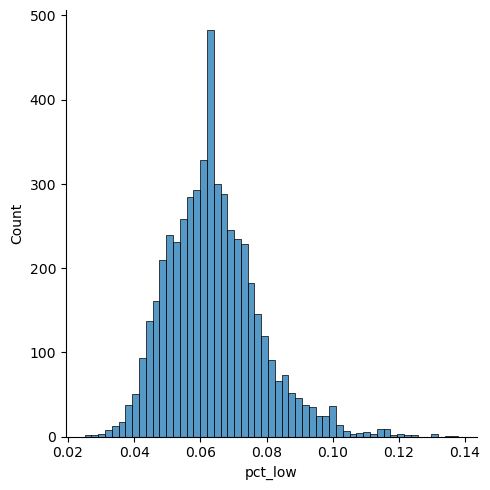

In [204]:
sns.displot(df['pct_low']);

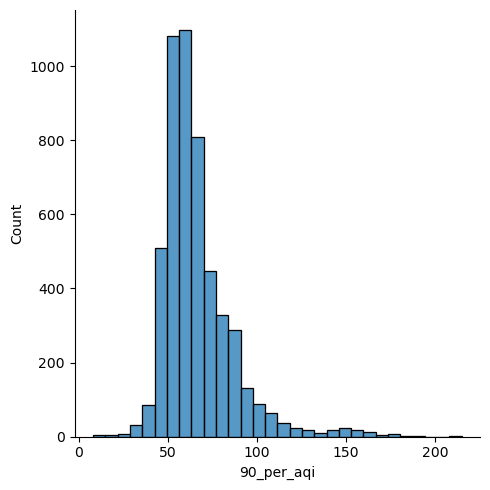

In [208]:
sns.displot(df['90_per_aqi'],
            bins=30)

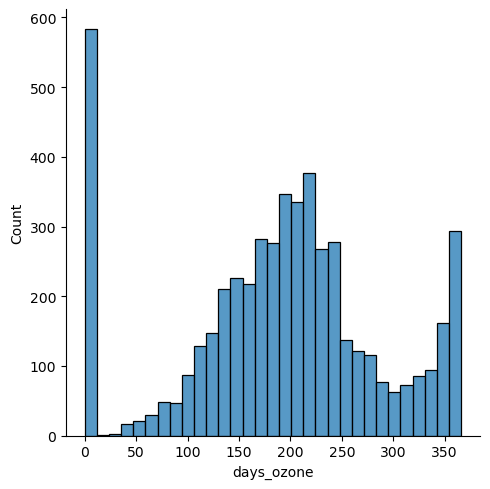

In [210]:
sns.displot(df['days_ozone'])

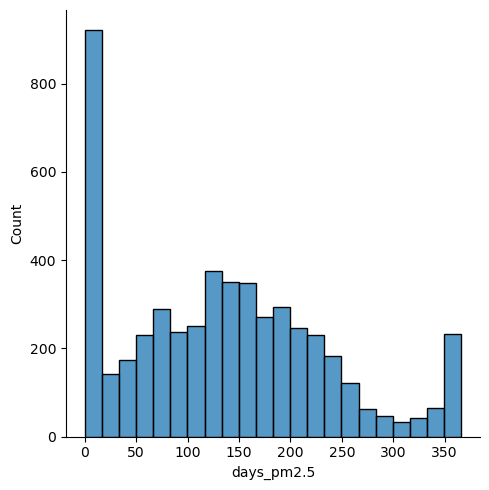

In [211]:
sns.displot(df['days_pm2.5'])

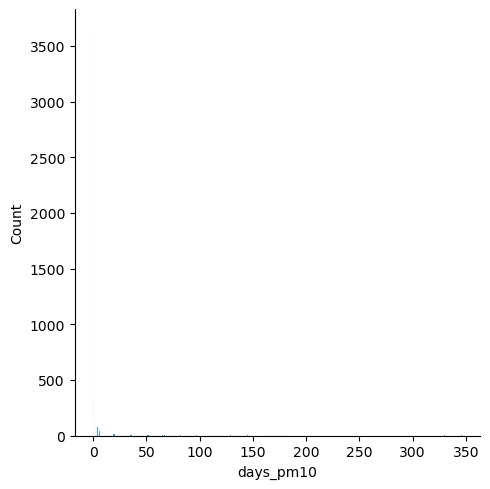

In [212]:
sns.displot(df['days_pm10'])

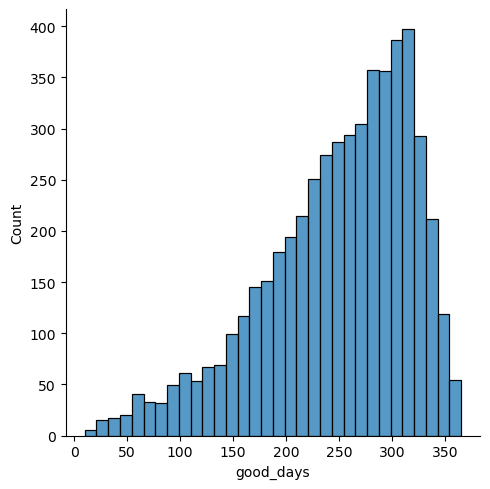

In [213]:
sns.displot(df['good_days'])

What are the state/county combos with the highest percentage of low birthweight?

In [198]:
df.sort_values(by='pct_low', ascending=False).head(10)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_ozone,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low
309,Georgia,Clayton,2020,121,103,18,0,0,0,0,...,0,121,0,396.0,1977.646,35.005,2874.0,3078.496,38.191,0.138
4992,Louisiana,Caddo,2010,363,261,91,11,0,0,0,...,303,60,0,402.0,1977.264,33.945,2986.0,3088.602,37.874,0.135
1984,Mississippi,Hinds,2014,365,180,184,0,1,0,0,...,91,274,0,363.0,1931.003,33.959,2779.0,3065.051,37.917,0.131
434,Mississippi,Hinds,2020,366,249,116,1,0,0,0,...,101,265,0,290.0,2035.279,34.610,2226.0,3081.211,37.933,0.130
4706,Louisiana,Caddo,2011,365,240,107,18,0,0,0,...,297,68,0,372.0,1939.624,33.747,2871.0,3099.827,37.870,0.130
2864,Mississippi,Hinds,2017,365,256,109,0,0,0,0,...,114,243,0,322.0,1909.012,33.643,2572.0,3069.387,37.916,0.125
320,Georgia,Richmond,2020,366,268,97,1,0,0,0,...,84,267,15,262.0,1965.233,34.351,2099.0,3124.365,38.307,0.125
3855,Mississippi,Hinds,2012,366,241,122,2,1,0,0,...,117,249,0,327.0,1986.190,34.217,2668.0,3082.299,37.973,0.123
1524,Mississippi,Hinds,2019,365,256,109,0,0,0,0,...,143,222,0,290.0,2038.310,34.379,2351.0,3094.378,37.923,0.123
2403,Mississippi,Hinds,2015,365,217,148,0,0,0,0,...,110,253,0,307.0,1967.857,34.094,2566.0,3085.500,37.993,0.120


I see there are some entries here that look to have only 120 days or so of recording data (looking at the days_with_aqi).  Let's filter ones that have at least 300 so we're getting at least 10 months of data.

In [195]:
df_300 = df[df['days_with_aqi'] > 300]

In [196]:
df_300.sort_values(by='pct_low', ascending=False).head(10)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_ozone,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low
4992,Louisiana,Caddo,2010,363,261,91,11,0,0,0,...,303,60,0,402.0,1977.264,33.945,2986.0,3088.602,37.874,0.135
1984,Mississippi,Hinds,2014,365,180,184,0,1,0,0,...,91,274,0,363.0,1931.003,33.959,2779.0,3065.051,37.917,0.131
434,Mississippi,Hinds,2020,366,249,116,1,0,0,0,...,101,265,0,290.0,2035.279,34.610,2226.0,3081.211,37.933,0.130
4706,Louisiana,Caddo,2011,365,240,107,18,0,0,0,...,297,68,0,372.0,1939.624,33.747,2871.0,3099.827,37.870,0.130
320,Georgia,Richmond,2020,366,268,97,1,0,0,0,...,84,267,15,262.0,1965.233,34.351,2099.0,3124.365,38.307,0.125
2864,Mississippi,Hinds,2017,365,256,109,0,0,0,0,...,114,243,0,322.0,1909.012,33.643,2572.0,3069.387,37.916,0.125
3855,Mississippi,Hinds,2012,366,241,122,2,1,0,0,...,117,249,0,327.0,1986.190,34.217,2668.0,3082.299,37.973,0.123
1524,Mississippi,Hinds,2019,365,256,109,0,0,0,0,...,143,222,0,290.0,2038.310,34.379,2351.0,3094.378,37.923,0.123
2340,Louisiana,Caddo,2015,364,303,61,0,0,0,0,...,278,86,0,303.0,1905.512,33.515,2515.0,3110.653,37.936,0.120
4386,Virginia,Hampton City,2013,359,313,44,2,0,0,0,...,165,181,0,48.0,1738.479,32.729,399.0,3205.329,38.266,0.120


What are the year/county combinations that have the smallest percentage?

In [197]:
df_300.sort_values(by='pct_low', ascending=True).head(10)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_ozone,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low
494,New York,Tompkins,2020,364,359,5,0,0,0,0,...,364,0,0,13.0,2204.077,35.077,530.0,3403.653,39.079,0.025
1584,New York,Tompkins,2019,356,349,7,0,0,0,0,...,356,0,0,14.0,2174.000,35.571,510.0,3414.189,39.043,0.027
1264,Washington,Cowlitz,2018,365,338,23,2,2,0,0,...,0,365,0,23.0,2147.913,35.304,819.0,3456.101,38.976,0.028
2142,Washington,Cowlitz,2014,323,309,14,0,0,0,0,...,0,323,0,24.0,1982.417,34.125,804.0,3443.707,39.232,0.030
1636,Oregon,Linn,2019,365,280,83,2,0,0,0,...,0,365,0,33.0,2000.636,33.939,1048.0,3498.659,39.032,0.031
671,California,Humboldt,2008,364,349,15,0,0,0,0,...,286,50,4,37.0,1884.730,33.556,1168.0,3430.532,38.935,0.032
3435,Oregon,Linn,2016,366,333,33,0,0,0,0,...,0,366,0,33.0,2068.242,34.424,1027.0,3460.391,39.009,0.032
1647,Pennsylvania,Centre,2019,365,267,98,0,0,0,0,...,203,162,0,27.0,2042.370,34.296,819.0,3428.707,39.076,0.033
3076,Wisconsin,La Crosse,2017,360,311,49,0,0,0,0,...,194,166,0,27.0,2059.185,33.889,819.0,3462.660,39.269,0.033
3443,Pennsylvania,Blair,2016,366,285,79,2,0,0,0,...,196,166,4,28.0,1989.750,34.143,846.0,3410.701,38.995,0.033


# PARKING LOT

In [74]:
births = pd.read_csv('data/cdc_cleaned.csv')

In [75]:
births.head()

,state,county,year,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low
0,Alabama,Baldwin,2014,137.0,1995.255,34.051,1724.0,3296.472,38.489,0.079
1,Alabama,Baldwin,2015,141.0,1832.837,32.922,1857.0,3290.811,38.347,0.076
2,Alabama,Baldwin,2016,120.0,2008.358,34.058,1722.0,3315.387,38.497,0.070
3,Alabama,Baldwin,2017,100.0,2082.830,34.380,1782.0,3346.588,38.572,0.056
4,Alabama,Baldwin,2018,122.0,1942.303,33.508,1770.0,3301.324,38.423,0.069


In [76]:
births.shape

(6094, 10)

In [77]:
births.describe()

,year,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low
count,6094.000000,6094.000000,6094.000000,6094.000000,6094.000000,6094.000000,6094.000000,6094.000000
mean,2015.556285,314.028224,1989.488184,34.113257,4714.525271,3317.070518,38.647829,0.063820
std,3.856319,572.645302,62.995391,0.507744,8418.105318,65.225411,0.204450,0.013906
min,2007.000000,13.000000,1682.821000,31.750000,399.000000,3065.051000,37.726000,0.025000
25%,2013.000000,80.000000,1950.083250,33.814000,1323.000000,3274.358500,38.522000,0.054000
50%,2016.000000,137.000000,1989.376000,34.117000,2195.000000,3320.209500,38.647000,0.063000
75%,2019.000000,325.750000,2028.819500,34.418750,4873.500000,3363.171000,38.783000,0.072000
max,2021.000000,9406.000000,2269.811000,36.378000,137740.000000,3498.659000,39.289000,0.138000


In [78]:
births['year'].value_counts()

2020    563
2021    563
2016    551
2017    551
2018    551
2019    551
2015    493
2014    487
2013    380
2012    341
2011    308
2010    228
2009    183
2008    179
2007    165
Name: year, dtype: int64

In [79]:
set(births[births['year'] == 2007]['county'])

{'Adams',
 'Alameda',
 'Albany',
 'Allen',
 'Arapahoe',
 'Ashtabula',
 'Bell',
 'Bexar',
 'Black Hawk',
 'Boulder',
 'Brazoria',
 'Brazos',
 'Broome',
 'Butler',
 'Butte',
 'Cameron',
 'Cass',
 'Chautauqua',
 'Chittenden',
 'Clark',
 'Clermont',
 'Collin',
 'Columbiana',
 'Contra Costa',
 'Cuyahoga',
 'Dallas',
 'Delaware',
 'Denton',
 'Denver',
 'Douglas',
 'Dutchess',
 'Ector',
 'El Dorado',
 'El Paso',
 'Elkhart',
 'Ellis',
 'Erie',
 'Fairfield',
 'Fort Bend',
 'Franklin',
 'Fresno',
 'Galveston',
 'Grayson',
 'Greene',
 'Gregg',
 'Hamilton',
 'Harris',
 'Hendricks',
 'Hidalgo',
 'Hillsborough',
 'Humboldt',
 'Imperial',
 'Jefferson',
 'Johnson',
 'Kent',
 'Kern',
 'Kings',
 'La Porte',
 'Lake',
 'Larimer',
 'Licking',
 'Linn',
 'Lorain',
 'Los Angeles',
 'Lubbock',
 'Lucas',
 'Madera',
 'Madison',
 'Mahoning',
 'Marin',
 'Marion',
 'Mclennan',
 'Medina',
 'Merced',
 'Merrimack',
 'Mesa',
 'Midland',
 'Minnehaha',
 'Monroe',
 'Monterey',
 'Montgomery',
 'Napa',
 'Nassau',
 'New Cast

In [80]:
# how many counties from the aqi are also in the cdc data
# len(set(aqi['county']).intersection(set(cdc['County'])))

In [81]:
# what are the differences
#set(aqi['county']).difference(set(cdc['County']))

### EPA API Information

Look to see if getting more granular data from the API is feasible

Your user ID is your email address: mrhurless@gmail.com 
Your key is: rubymouse94 

In [82]:
# import requests

In [83]:
# email = 'mrhurless@gmail.com'
# key = 'rubymouse94'

# url = f'https://aqs.epa.gov/data/api/list/parametersByClass?email={email}&key={key}&pc=CRITERIA'

# res = requests.get(url)

# res.status_code

In [84]:
# # from https://stackoverflow.com/questions/71603314/ssl-error-unsafe-legacy-renegotiation-disabled

# import urllib3
# import ssl

# class CustomHttpAdapter (requests.adapters.HTTPAdapter):
#     # "Transport adapter" that allows us to use custom ssl_context.

#     def __init__(self, ssl_context=None, **kwargs):
#         self.ssl_context = ssl_context
#         super().__init__(**kwargs)

#     def init_poolmanager(self, connections, maxsize, block=False):
#         self.poolmanager = urllib3.poolmanager.PoolManager(
#             num_pools=connections, maxsize=maxsize,
#             block=block, ssl_context=self.ssl_context)


# def get_legacy_session():
#     ctx = ssl.create_default_context(ssl.Purpose.SERVER_AUTH)
#     ctx.options |= 0x4  # OP_LEGACY_SERVER_CONNECT
#     session = requests.session()
#     session.mount('https://', CustomHttpAdapter(ctx))
#     return session

In [85]:
# res = get_legacy_session().get(url)

In [86]:
def get_aqi():
    creds = ('mhurless@me.com', '0n3L0v3#')
    email = 'mrhurless@gmail.com'
    key = 'rubymouse94'
    all_posts = []
    
    url = "https://support.brightsign.biz/api/v2/community/posts"
    
    res = requests.get(url, auth=creds)
    
    # get data other than posts data
    metadata = {
                key: value for key, value in res.json().items() 
                if key != 'posts'
            }
    
    last_page = metadata['page_count']
    current_page = metadata['page']
    
    #count = 0 #keep track of posts # don't think this is needed with this
    # approach

    # goal is to get posts from all pages, so we'll check if we've reached 
    # the last page, but will also put in a catch for the rate limit as 
    # mentioned by the API docs
    
    while current_page <= last_page:
        res = requests.get(url, auth=creds)

        if res.status_code == 200:
            posts = pd.DataFrame(res.json()['posts'])
            metadata = {
                key: value for key, value in res.json().items() 
                if key != 'posts'
            }
            
            # update current page
            current_page = metadata['page']
            
            # update URL to pull posts from next page
            url = metadata['next_page']

            all_posts.append(posts)
            
            #sleep(5)

            if metadata['page'] == metadata['page_count']: 
                break #break loop if last page is reached

            #get sequential posts from most recent to least    
            #params['before'] = posts['created_utc'].min()
        elif res.status_code == 429:
            sleep(res.headers['retry-after'])
        else:
            print(f'status: {res.status_code}')  
    print(f'posts retrieved from API: {len(all_posts)}')

    return pd.concat(all_posts)